# Recommendation System

You will be making movie recommendations based on the <a href="https://grouplens.org/datasets/movielens/latest/">MovieLens dataset</a> from the GroupLens research lab at the University of Minnesota. Unless you are planning to run your analysis on a paid cloud platform, we recommend that you use the "small" dataset containing 100,000 user ratings (and potentially, only a particular subset of that dataset).

Your task is to:

    Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

The MovieLens dataset is a "classic" recommendation system dataset, that is used in numerous academic papers and machine learning proofs-of-concept. You will need to create the specific details about how the user will provide their ratings of other movies, in addition to formulating a more specific business problem within the general context of "recommending movies".

#### Collaborative Filtering
At minimum, your recommendation system must use collaborative filtering. If you have time, consider implementing a hybrid approach, e.g. using collaborative filtering as the primary mechanism, but using content-based filtering to address the <a href="https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)">cold start</a> problem.

#### Evaluation
The MovieLens dataset has explicit ratings, so achieving some sort of evaluation of your model is simple enough. But you should give some thought to the question of metrics. Since the rankings are ordinal, we know we can treat this like a regression problem. But when it comes to regression metrics there are several choices: RMSE, MAE, etc. Here are some further ideas.

## Import Packages

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, avg
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Start a spark session
spark = SparkSession.builder.getOrCreate()

## Data

### Import Data

In [2]:
# Download the data

# ! wget -P ../../data http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [3]:
# Unzip the data

# with zipfile.ZipFile('../../data/ml-latest-small.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data')

In [4]:
# Read in the data with spark DataFrames
links = spark.read.csv('../../data/ml-latest-small/links.csv', inferSchema=True, header=True)
movies = spark.read.csv("../../data/ml-latest-small/movies.csv", inferSchema=True, header=True)
ratings = spark.read.csv("../../data/ml-latest-small/ratings.csv", inferSchema=True, header=True)
tags = spark.read.csv("../../data/ml-latest-small/tags.csv", inferSchema=True, header=True)

### Data exploration & manipulation

In [5]:
# Join tabels
df = ratings.join(movies, ["movieID"], "left")
df = df.join(tags, ["userID", "movieID"], "left")

df.show(10)

+------+-------+------+---------+--------------------+--------------------+----+---------+
|userId|movieId|rating|timestamp|               title|              genres| tag|timestamp|
+------+-------+------+---------+--------------------+--------------------+----+---------+
|     1|      1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|null|     null|
|     1|      3|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|null|     null|
|     1|      6|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|null|     null|
|     1|     47|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|null|     null|
|     1|     50|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|null|     null|
|     1|     70|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|null|     null|
|     1|    101|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|null|     null|
|     1|    110|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|null|     null|

In [6]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



#### Calculating Sparsity

In [7]:
# Count the total number of ratings in the dataset
numerator = df.select("rating").count()

# Count the number of distinct userIds and distinct movieIds
num_users = df.select("userId").distinct().count()
num_movies = df.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.27% empty.


#### Ratings Summary Statistics

In [8]:
# Min num ratings for movies
print("Movie with the fewest ratings: ")
df.groupBy("movieID").count().select(min("count")).show()

# Avg num ratings per movie
print("Avg num ratings per movie: ")
df.groupBy("movieID").count().select(avg("count")).show()

# Min num ratings for user
print("User with the fewest ratings: ")
df.groupBy("userID").count().select(min("count")).show()

# Avg num ratings per users
print("Avg num ratings per user: ")
df.groupBy("userID").count().select(avg("count")).show()

print("Num of users: " + str(df.groupBy("userID").count().count()))
print("Num of movies: " + str(df.groupBy("movieID").count().count()))
print("Num of tags: " + str(df.groupBy("tag").count().count()))

print("Num of rows in ratings: " + str(ratings.count()))

print("Num of rows in tags: " + str(tags.count()))

print("Num of rows in combined dataframe: " + str(df.count()))

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+------------------+
|        avg(count)|
+------------------+
|10.559132044426162|
+------------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        20|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|168.32295081967214|
+------------------+

Num of users: 610
Num of movies: 9724
Num of tags: 1544
Num of rows in ratings: 100836
Num of rows in tags: 3683
Num of rows in combined dataframe: 102677


### Data Visualizations

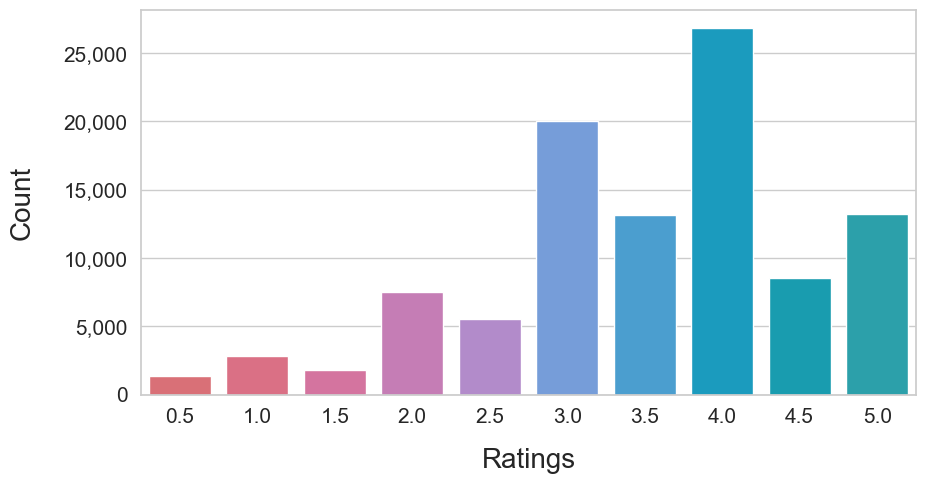

In [9]:
ratings_pd = pd.read_csv("../../data/ml-latest-small/ratings.csv")

# Create an array with the colors you want to use
# https://colordesigner.io/gradient-generator
# link generates a list of hex values between 2 given hexes
# Now I can match the powerpoint
hex_list = ["#eb5e68", "#ec5e7a", "#e4649d", "#d171bc", "#b580d4",
            "#669ae9", "#35a4e5", "#00abd9", "#00afc8", "#17b1bf"]
# Set your custom color palette
my_palette = sns.color_palette(hex_list, as_cmap=True)

plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.figure(figsize = (10, 5))
ax = sns.countplot(x="rating", data=ratings_pd, alpha=1, palette = my_palette)
plt.tick_params(labelsize = 15)
# plt.title("Distribution of Ratings in Movie Database", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20, labelpad=15)
plt.ylabel("Count", fontsize = 20,labelpad=20)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/ratings_dist.png', bbox_inches='tight', transparent=True);

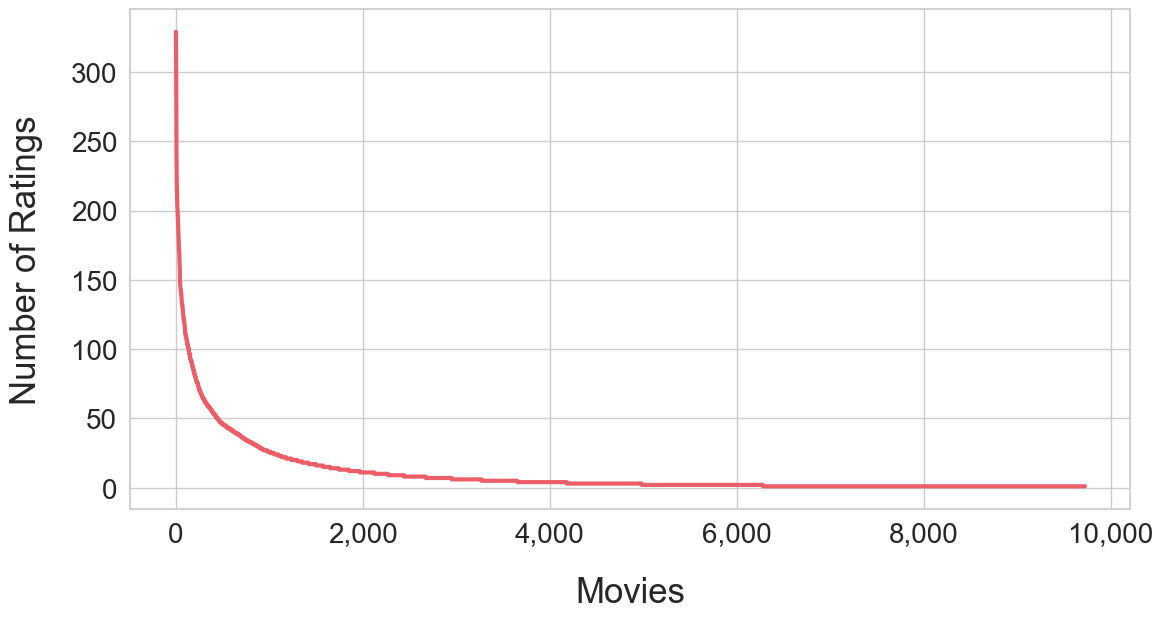

In [10]:
no_of_ratings_per_movie = ratings_pd.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)

fig = plt.figure(figsize = (10, 5))
axes = fig.add_axes([0.1,0.1,1,1])
# plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movies", fontsize = 25, labelpad=20)
plt.ylabel("Number of Ratings", fontsize = 25, labelpad=20)
plt.plot(no_of_ratings_per_movie.values, color='#eb5e68', linewidth=3)
plt.tick_params(labelsize = 20)
#axes.set_xticklabels([])
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/ratings_count_distribution.png', bbox_inches='tight', transparent=True);

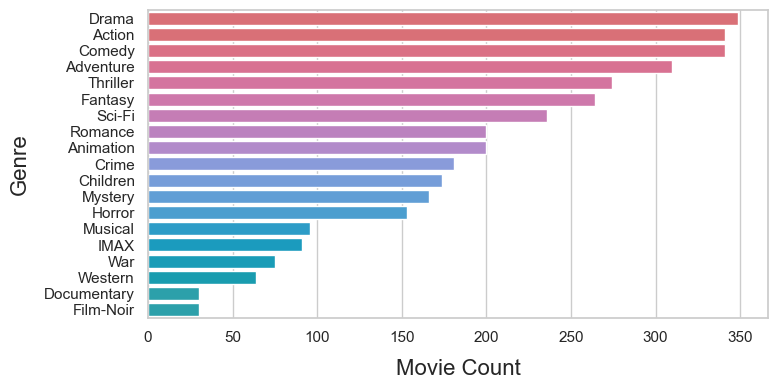

In [11]:
movies_pd = pd.read_csv("../../data/ml-latest-small/movies.csv")
movies_pd['genres'] = movies_pd['genres'].str.replace('|',' ')
movie_genres = movies_pd.genres.unique()
movie_genres = " ".join(movie_genres)
word_tokens = word_tokenize(movie_genres)
stopset = ['no', 'genres', 'listed', '(', ')']
cleanup = [token for token in word_tokens if token not in stopset]
bow = Counter(cleanup)
bow_dict = dict(bow)
bow_df = (pd.DataFrame.from_dict(bow_dict, orient='index', columns=["count"]))
bow_df.sort_values('count', ascending=False, inplace=True)
bow_df.reset_index(inplace=True)
bow_df.columns=['Genre', 'Movie Count']

# Create an array with the colors you want to use
# https://colordesigner.io/gradient-generator
# link generates a list of hex values between 2 given hexes
# Now I can match the powerpoint
hex_list = ["#eb5e68", "#eb5e68", "#ec5e7a", "#e9608c", "#e4649d",
            "#dc6aad", "#d171bc", "#c478c9", "#b580d4", "#7c94e7",
            "#669ae9", "#4e9fe8", "#35a4e5", "#14a7e0", "#00abd9",
            "#00add1", "#00afc8", "#17b1bf", "#17b1bf"]
# Set your custom color palette
my_palette = sns.color_palette(hex_list, as_cmap=True)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=bow_df['Movie Count'], y=bow_df['Genre'], alpha=1, palette = my_palette)
# ax.set_title("Genres by Frequency",fontsize=20)
ax.set_xlabel("Movie Count",fontsize=16, labelpad=10)
ax.set_ylabel("Genre",fontsize=16, labelpad=10)
# sns.despine(left=True)
plt.savefig('../../reports/figures/Genres.png', bbox_inches='tight', transparent=True);

## Collaborative Base Recommendation Engine

### Modeling

#### FSM

In [13]:
# Split the ratings dataframe into training and test data
(training_data, test_data) = df.randomSplit([.8, .2])

# Set the ALS hyperparameters
als_fsm = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative =True, implicitPrefs = False)

# Fit the model to the training_data
fsm = als_fsm.fit(training_data)

# Generate predictions on the test_data
test_predictions = fsm.transform(test_data)
test_predictions.show(10)

+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|prediction|
+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|   385|    471|   4.0| 850766697|Hudsucker Proxy, ...|              Comedy|null|     null| 3.2591813|
|    91|    471|   1.0|1112713817|Hudsucker Proxy, ...|              Comedy|null|     null|   2.89371|
|   218|    471|   4.0|1111624874|Hudsucker Proxy, ...|              Comedy|null|     null| 3.2137685|
|   217|    471|   2.0| 955943727|Hudsucker Proxy, ...|              Comedy|null|     null| 2.2725546|
|   555|    471|   3.0| 978746933|Hudsucker Proxy, ...|              Comedy|null|     null| 3.3718474|
|   448|    471|   4.0|1178980875|Hudsucker Proxy, ...|              Comedy|null|     null| 3.2792294|
|   312|    471|   4.0|1043175564|Hudsucker Proxy, ...|              Come

#### Build RMSE evaluator

In [14]:
# Complete the evaluator code
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [15]:
# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

0.870327437655836


#### Tuning Hyperparameters

In [16]:
# # Create ALS model
# als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
#           coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

In [17]:
# # Add hyperparameters and their respective values to param_grid
# param_grid = ParamGridBuilder() \
#             .addGrid(als.alpha, [0, .25, .5, .75, 1]) \
#             .addGrid(als.rank, [10, 25, 50, 75, 100]) \
#             .addGrid(als.regParam, [.05, .1, .15, .2]) \
#             .addGrid(als.maxIter, [5, 10, 15, 25, 50]) \
#             .build()


# print length of evaluator
# print ("Num models to be tested: ", len(param_grid))

In [18]:
# # Build cross validation using CrossValidator
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [19]:
# # Fit cross validator to the 'train' dataset
# model = cv.fit(train)

In [20]:
# # Extract best model from the cv model above
# best_model = model.bestModel

In [21]:
# # Extract the ALS model parameters
# print("**Best Model**")
# Print ("ParamMap")
# print("\n\n  ParamMap:", best_model._java_obj.parent().extractParamMap())

# # rank: 50
# # regParam=0.15
# # alpha=0
# # maxIter=10


#### Best Model

In [22]:
# New model with best params
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          alpha=0, rank=50, regParam=0.15, maxIter=10,
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
# Fit model to train
model = als.fit(training_data)

# Use mode to predict on test
test_predictions = model.transform(test_data)
test_predictions.show(10)

+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|prediction|
+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|   385|    471|   4.0| 850766697|Hudsucker Proxy, ...|              Comedy|null|     null| 3.2327192|
|    91|    471|   1.0|1112713817|Hudsucker Proxy, ...|              Comedy|null|     null|  2.983945|
|   218|    471|   4.0|1111624874|Hudsucker Proxy, ...|              Comedy|null|     null|   3.22686|
|   217|    471|   2.0| 955943727|Hudsucker Proxy, ...|              Comedy|null|     null| 2.8521564|
|   555|    471|   3.0| 978746933|Hudsucker Proxy, ...|              Comedy|null|     null|  3.429492|
|   448|    471|   4.0|1178980875|Hudsucker Proxy, ...|              Comedy|null|     null| 3.2142694|
|   312|    471|   4.0|1043175564|Hudsucker Proxy, ...|              Come

In [23]:
# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

0.8631374359913918


### Final recommendations

In [68]:
# Make 5 movie recommendations per user using their highest predicted ratings
recommendations = model.recommendForAllUsers(6)
# Print Some Prediction
recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("SELECT userId, movieIds_and_ratings.movieId AS movieId, movieIds_and_ratings.rating AS prediction FROM ALS_recs_temp LATERAL VIEW explode(recommendations) exploded_table AS movieIds_and_ratings")
clean_recs = clean_recs.join(movies, on=['movieId'], how='left').sort('userId')
clean_recs.show()

+-------+------+----------+--------------------+--------------------+
|movieId|userId|prediction|               title|              genres|
+-------+------+----------+--------------------+--------------------+
| 132333|     1| 5.7104306|         Seve (2014)|   Documentary|Drama|
|   5137|     1|  5.349809|      Scratch (2001)|         Documentary|
| 177593|     1|  5.409603|Three Billboards ...|         Crime|Drama|
|  33649|     1| 5.5963225|  Saving Face (2004)|Comedy|Drama|Romance|
|   6442|     1| 5.4188414| Belle époque (1992)|      Comedy|Romance|
|   5915|     1| 5.5673594|Victory (a.k.a. E...|    Action|Drama|War|
| 179135|     2| 4.6658845|Blue Planet II (2...|         Documentary|
|  84273|     2| 4.6658845|Zeitgeist: Moving...|         Documentary|
|   7071|     2| 4.6658845|Woman Under the I...|               Drama|
| 117531|     2| 4.6658845|    Watermark (2014)|         Documentary|
| 131724|     2| 4.8299565|The Jinx: The Lif...|         Documentary|
|  26073|     2| 4.6

In [69]:
# put in a random user number and return list of 5 titles
clean_recs

DataFrame[movieId: int, userId: int, prediction: float, title: string, genres: string]

In [70]:
df.filter(df["userId"]==168).filter(df["rating"]==5).count()

33

In [71]:
df.filter(df["userId"]==168).filter(df["rating"]==5).show(33)
# Average ratings per user is 168
# user 168 rated 94 movies
# Rated 33 movies as 5 star
# Some of these 33 movies include Fargo, American Beauty,
# Dr. Strangelove, the graduate, Touching the Void

+------+-------+------+----------+--------------------+--------------------+----+---------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|
+------+-------+------+----------+--------------------+--------------------+----+---------+
|   168|    608|   5.0|1306801670|        Fargo (1996)|Comedy|Crime|Dram...|null|     null|
|   168|    750|   5.0|1306801677|Dr. Strangelove o...|          Comedy|War|null|     null|
|   168|    858|   5.0|1306801724|Godfather, The (1...|         Crime|Drama|null|     null|
|   168|    908|   5.0|1306802820|North by Northwes...|Action|Adventure|...|null|     null|
|   168|    923|   5.0|1306801900| Citizen Kane (1941)|       Drama|Mystery|null|     null|
|   168|   1086|   5.0|1306801729|Dial M for Murder...|Crime|Mystery|Thr...|null|     null|
|   168|   1089|   5.0|1306802560|Reservoir Dogs (1...|Crime|Mystery|Thr...|null|     null|
|   168|   1172|   5.0|1306801666|Cinema Paradiso (...|               Drama|null

In [80]:
# Here's what we recomment to user 168
clean_recs.filter(clean_recs["userId"]==168).show(6, False)

+-------+------+----------+-----------------------------------------------------+---------------------------+
|movieId|userId|prediction|title                                                |genres                     |
+-------+------+----------+-----------------------------------------------------+---------------------------+
|7767   |168   |5.1663036 |Best of Youth, The (La meglio gioventù) (2003)       |Drama                      |
|132333 |168   |5.1028066 |Seve (2014)                                          |Documentary|Drama          |
|3266   |168   |5.046571  |Man Bites Dog (C'est arrivé près de chez vous) (1992)|Comedy|Crime|Drama|Thriller|
|5915   |168   |5.01665   |Victory (a.k.a. Escape to Victory) (1981)            |Action|Drama|War           |
|2131   |168   |5.0101094 |Autumn Sonata (Höstsonaten) (1978)                   |Drama                      |
|7096   |168   |5.004991  |Rivers and Tides (2001)                              |Documentary                |
+-------+-

## Content Based Recommender

In [26]:
tags_pd = pd.read_csv("../../data/ml-latest-small/tags.csv")
movies_pd = pd.read_csv("../../data/ml-latest-small/movies.csv")
content_pd = movies_pd.merge(tags_pd, on = "movieId", how='left')
content_pd.tag.fillna("", inplace=True)

# Separate the words in the genres column
content_pd['genres'] = content_pd['genres'].str.replace('|',' ')

# Since we have multiple tags for some movies from different users,
# we will make a combined tags column to combine those different tags for each movie
# and make a dataframe that has one row per movie
movie_Ids = content_pd.movieId.unique()
for movie in movie_Ids:
    m = content_pd[content_pd.movieId == movie]
    t = ""
    for x in m.values:
        if x[4] not in t:
            t+= x[4]+" "
    content_pd.loc[content_pd['movieId']==movie, 'combined_tags']=t
    
    
content_pd = content_pd[['movieId', 'title', 'genres', 'combined_tags']]
content_pd.drop_duplicates(inplace=True)
content_pd.reset_index(inplace=True)

In [27]:
content_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          9742 non-null   int64 
 1   movieId        9742 non-null   int64 
 2   title          9742 non-null   object
 3   genres         9742 non-null   object
 4   combined_tags  9742 non-null   object
dtypes: int64(2), object(3)
memory usage: 380.7+ KB


In [28]:
features = ['combined_tags']

def combine_features(row):
    return row['genres'] +" "+row['combined_tags']

for feature in features:
    content_pd[feature] = content_pd[feature].fillna('')
    
content_pd["combined_features"] = content_pd.apply(combine_features,axis=1)

cv = CountVectorizer()
count_matrix = cv.fit_transform(content_pd["combined_features"])

cosine_sim = cosine_similarity(count_matrix)

def get_title_from_index(index):
    return content_pd[content_pd.index == index]["title"].values[0]

def get_index_from_title(title):
    return content_pd[content_pd.title == title].index[0]

movie_user_likes = "Jumanji (1995)"
movie_index = get_index_from_title(movie_user_likes)
similar_movies =  list(enumerate(cosine_sim[movie_index]))
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]
i=0

print("Top 5 similar movies to "+movie_user_likes+" are:\n")

for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>=5:
        break

Top 5 similar movies to Jumanji (1995) are:

Indian in the Cupboard, The (1995)
NeverEnding Story III, The (1994)
Escape to Witch Mountain (1975)
Darby O'Gill and the Little People (1959)
Return to Oz (1985)


In [30]:
def similar_movies(title):
    movie_index = get_index_from_title(title)
    similar_movies =  list(enumerate(cosine_sim[movie_index]))
    sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]
    i=0
    
    print("\nTop 5 similar movies to "+title+" are:\n")
    
    for element in sorted_similar_movies:
        print(get_title_from_index(element[0]))
        i=i+1
        if i>=5:
            break

In [31]:
sample_movies= ['Eternal Sunshine of the Spotless Mind (2004)', 'Blank Check (1994)',
                '28 Days Later (2002)', 'Kung Fu Panda: Secrets of the Masters (2011)', '10 Things I Hate About You (1999)']

for title in sample_movies:
    similar_movies(title)


Top 5 similar movies to Eternal Sunshine of the Spotless Mind (2004) are:

Moonrise Kingdom (2012)
Donnie Darko (2001)
Teknolust (2002)
I'm a Cyborg, But That's OK (Saibogujiman kwenchana) (2006)
Buffalo '66 (a.k.a. Buffalo 66) (1998)

Top 5 similar movies to Blank Check (1994) are:

Dunston Checks In (1996)
Heavyweights (Heavy Weights) (1995)
Richie Rich (1994)
Little Rascals, The (1994)
Harriet the Spy (1996)

Top 5 similar movies to 28 Days Later (2002) are:

Hellraiser: Bloodline (1996)
Alien: Resurrection (1997)
Deep Rising (1998)
Alligator (1980)
Chopping Mall (a.k.a. Killbots) (1986)

Top 5 similar movies to Kung Fu Panda: Secrets of the Masters (2011) are:

Charlotte's Web (1973)
King and I, The (1999)
Doug's 1st Movie (1999)
Batman: Mask of the Phantasm (1993)
Tigger Movie, The (2000)

Top 5 similar movies to 10 Things I Hate About You (1999) are:

Rosencrantz and Guildenstern Are Dead (1990)
Much Ado About Nothing (1993)
Twelfth Night (1996)
Two if by Sea (1996)
French Twist

### Visualize the genres and tags

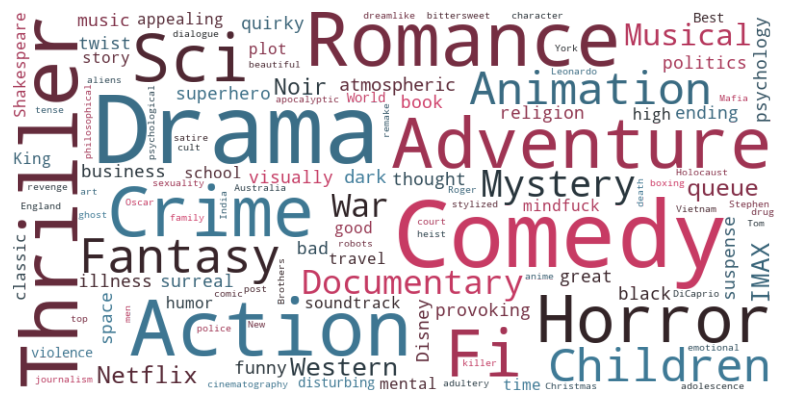

In [32]:
text = " ".join(feature for feature in content_pd["combined_features"])
stopwords = ['no', 'genres', 'listed', '(', ')', 'based', 'Film', 'movie', 'imdb',
             'of', 'Coen', 'and', 'II', 'a', 'the', 'r', 'in', 'on', 'will']
custom_palette = sns.diverging_palette(0, 230, l=50, center="dark", as_cmap=True)


# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, background_color="rgba(255, 255, 255, 0)", collocations=False,
                     max_font_size=100, margin=4, relative_scaling=.3, min_font_size=10, max_words=150,
                     width=800, height=400, colormap=custom_palette, mode="RGBA").generate(text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [33]:
wordcloud.to_file("../../reports/figures/word_cloud_3.png");

## Ratings Based Generald Recommender

In [49]:
movies_df = pd.read_csv('../../data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('../../data/ml-latest-small/ratings.csv')

movie_ratings = ratings_df.merge(movies_df, on=["movieId"])

movie_ratings["liked"] = movie_ratings['rating'].apply(lambda x: 1 if x >= 4.0 else 0)

def get_title_from_movie_id(movie_id):
    return movie_ratings[movie_ratings.movieId == movie_id]["title"].values[0]

def newbayes_ucb1_policy(df, ucb_scale=2.0):
    '''
    Applies Bayesian UCB policy to generate movie recommendations
    Args:
        df: dataframe. Dataset to apply Bayesian UCB policy to.
        ucb_scale: float. Most implementations use 2.0.
    '''
    scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
    scores.columns = ['mean', 'count', 'std']
    scores['ucb'] = scores['mean'] + (ucb_scale * scores['std'] / np.sqrt(scores['count']))
    scores['movieId'] = scores.index
    scores = scores.sort_values('ucb', ascending=False)
    recs = scores.loc[scores.index[0:6], 'movieId'].values
    movie_name = []
    for movieid in recs:
        movie_name.append(get_title_from_movie_id(movieid))
    return movie_name


In [50]:
newbayes_ucb1_policy(ratings_pd, ucb_scale=2.0)

['Mission: Impossible - Fallout (2018)',
 "Metal: A Headbanger's Journey (2005)",
 'Deep End of the Ocean, The (1999)',
 'Program, The (1993)',
 'Take the Lead (2006)',
 'Down in the Valley (2005)']

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df[df]